In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt

In [10]:
users = pd.read_csv('../data/users.csv')
places = pd.read_csv('../data/all_places.csv', encoding='MacRoman')
ratings = pd.read_csv('../data/ratings.csv')

# Step 1: Calculate the average rating for each place
average_ratings = ratings.groupby('Place ID')['Rating'].mean()

# Step 2: Merge average ratings with the places DataFrame
places = places.merge(average_ratings, left_on='id', right_index=True, how='left')

# Step 3: Rename the merged column to "average rating"
places = places.rename(columns={'Rating': 'Avg rating'})

# Step 4: Fill NaN values with a default value (e.g., 0)
places['Avg rating'] = places['Avg rating'].fillna(0)

In [11]:
places.head()

,id,name,address,city_id,location,desciption,time,stars,food type,price,place_type,Avg rating
0,1,Galleria Alberto Sordi,Piazza Colonna 00187 Roma RM Italy,1,41.90122340938924 12.480575693552845,Galleria Alberto Sordi is a historic shopping ...,2.0,NaN,NaN,NaN,shopping,3.521739
1,2,Via del Corso,"Via del Corso, 00186 Roma RM, Italy",1,41.903369974944845 12.479473708895839,Via del Corso is one of the main shopping stre...,3.0,NaN,NaN,NaN,shopping,3.630137
2,3,Via Condotti,"Via dei Condotti, 00187 Roma RM, Italy",1,41.90533403993258 12.480541881910383,"Via Condotti is a prestigious street in Rome, ...",4.0,NaN,NaN,NaN,shopping,3.717391
3,4,La Rinascente,"Via del Tritone, 61, 00187 Roma RM, Italy",1,41.90600659996459 12.484760359092748,La Rinascente is a famous department store in ...,4.0,NaN,NaN,NaN,shopping,3.478261
4,5,Porta Portese Market,"Via di Porta Portese, 00153 Roma RM, Italy",1,41.87621365001004 12.467844220464272,Porta Portese Market is one of the largest fle...,5.0,NaN,NaN,NaN,shopping,3.478261


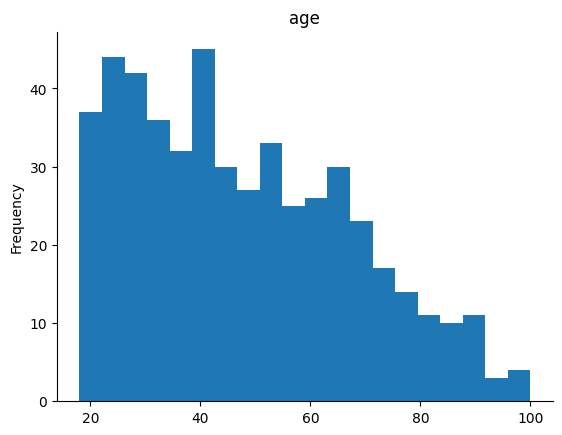

In [12]:
users['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [13]:
merged_df = pd.merge(ratings, places,left_on='Place ID',right_on='id')
merged_df = pd.merge(merged_df, users, left_on='User ID', right_on='id')
# users = merged_df[['User ID', 'age', 'gender', 'country', 'Place ID', 'Rating']]
# users

# Calculate average rating per place_type per user
avg_ratings = merged_df.groupby(['User ID', 'place_type'])['Rating'].mean().reset_index()

# Pivot the data to create columns for each place_type
avg_ratings_pivot = avg_ratings.pivot(index='User ID', columns='place_type', values='Rating')

# Add the new columns to merged_df
merged_df = merged_df.merge(avg_ratings_pivot, on='User ID')

# Rename the columns
merged_df.rename(columns={'Shopping': 'Shopping Avg',
                          'Hotel': 'Hotel Avg',
                          'Night': 'Night Avg',
                          'Old': 'Old Avg'}, inplace=True)

merged_df.head()

,User ID,Place ID,Rating,id_x,name,address,city_id,location,desciption,time,...,email,gender,age,country,hotel,natural,night,old,restaurant,shopping
0,1,1,5,1,Galleria Alberto Sordi,Piazza Colonna 00187 Roma RM Italy,1,41.90122340938924 12.480575693552845,Galleria Alberto Sordi is a historic shopping ...,2.0,...,wsparhawk0@va.gov,Female,37,Brazil,3.384615,3.75,3.333333,3.428571,3.666667,3.461538
1,1,7,3,7,Castel Romano Designer Outlet,"Via Ponte di Piscina Cupa, 64, 00128 Castel Ro...",1,41.71704125708646 12.444494881898068,Castel Romano Designer Outlet is a popular sho...,5.0,...,wsparhawk0@va.gov,Female,37,Brazil,3.384615,3.75,3.333333,3.428571,3.666667,3.461538
2,1,22,3,22,Via della Spiga,"- 20121 Milan, Italy",2,45.470518753830376 9.196549191379225,Via della Spiga: A fashionable street lined wi...,4.0,...,wsparhawk0@va.gov,Female,37,Brazil,3.384615,3.75,3.333333,3.428571,3.666667,3.461538
3,1,24,3,24,Corso Como,"Corso Como, 10, 20154 Milan, Italy",2,45.48236584610254 9.1873938220679,Corso Como: A trendy district known for its co...,3.0,...,wsparhawk0@va.gov,Female,37,Brazil,3.384615,3.75,3.333333,3.428571,3.666667,3.461538
4,1,37,5,37,Coin Excelsior,"Piazza Cinque Giornate, 1, 20129 Milan, Italy",2,45.46726490934323 9.186248749733645,Coin Excelsior: A department store featuring a...,2.0,...,wsparhawk0@va.gov,Female,37,Brazil,3.384615,3.75,3.333333,3.428571,3.666667,3.461538


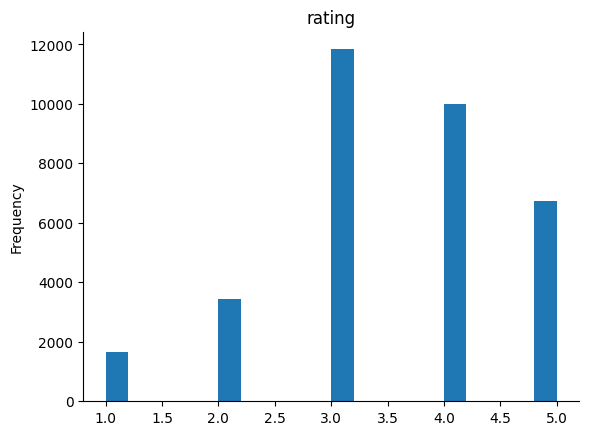

In [14]:
merged_df['Rating'].plot(kind='hist', bins=20, title='rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [17]:
Y = merged_df["Rating"].values
Xu = merged_df[['age', 'gender','country', 'hotel', 'natural', 'night', 'old', 'restaurant', 'shopping']]
Xp = merged_df[['place_type', 'city_id', 'Avg rating']]

Feature Extraction

In [18]:
label_encoder_gender = LabelEncoder()
label_encoder_country = LabelEncoder()
label_encoder_place_type = LabelEncoder()
label_encoder_city = LabelEncoder()

label_encoder_gender.fit(Xu['gender'])
label_encoder_country.fit(Xu['country'])
label_encoder_place_type.fit(Xp['place_type'])
label_encoder_city.fit(Xp['city_id'])

Xu['gender'] = label_encoder_gender.transform(Xu['gender'])
Xu['country'] = label_encoder_country.transform(Xu['country'])
Xp['place_type'] = label_encoder_place_type.transform(Xp['place_type'])
Xp['city_id'] = label_encoder_city.transform(Xp['city_id'])

C:\Users\96393\AppData\Local\Temp\ipykernel_18964\3722801017.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xu['gender'] = label_encoder_gender.transform(Xu['gender'])
C:\Users\96393\AppData\Local\Temp\ipykernel_18964\3722801017.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xu['country'] = label_encoder_country.transform(Xu['country'])
C:\Users\96393\AppData\Local\Temp\ipykernel_18964\3722801017.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

Scale training data

In [21]:
item_train_unscaled = Xp
user_train_unscaled = Xu
y_train_unscaled = Y

scalerItem = StandardScaler()
scalerItem.fit(Xp)
item_train = scalerItem.transform(Xp)

scalerUser = StandardScaler()
scalerUser.fit(Xu)
user_train = scalerUser.transform(Xu)

scalerTarget = MinMaxScaler((-1, 1))
scalerTarget.fit(Y.reshape(-1, 1))
y_train = scalerTarget.transform(Y.reshape(-1, 1))

Spliting the data into training and testing

In [22]:
item_train, item_test = train_test_split(item_train, train_size=0.80, shuffle=True, random_state=1)
user_train, user_test = train_test_split(user_train, train_size=0.80, shuffle=True, random_state=1)
y_train, y_test = train_test_split(y_train, train_size=0.80, shuffle=True, random_state=1)
print(f"place/item training data shape: {item_train.shape}")
print(f"user train data shape: {user_train.shape}")
print(f"y train data shape: {y_train.shape}")

place/item training data shape: (26941, 3)
user train data shape: (26941, 9)
y train data shape: (26941, 1)


Building the user's NN

In [25]:
tf.random.set_seed(1)
user_NN = keras.models.Sequential([
    keras.layers.Dense(256 , activation='relu'),
    keras.layers.Dense(128 ,activation='relu'),
    keras.layers.Dense(32)
])

Building the place's NN

In [26]:
item_NN = tf.keras.models.Sequential([
    keras.layers.Dense(256 ,activation='relu'),
    keras.layers.Dense(128 ,activation='relu'),
    keras.layers.Dense(32)
])

In [27]:
# create the user input and point to the base network
input_user = tf.keras.layers.Input(shape=(9))
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1)

In [28]:
# create the item input and point to the base network
input_item = tf.keras.layers.Input(shape=(3))
vm = item_NN(input_item)
vm = tf.linalg.l2_normalize(vm, axis=1)

In [29]:
# compute the dot product of the two vectors vu and vm
output = tf.keras.layers.Dot(axes=1)([vu, vm])

In [30]:
# specify the inputs and output of the model
model = tf.keras.Model([input_user, input_item], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 9)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 3)]                  0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 32)                   39584     ['input_1[0][0]']             
                                                                                                  
 sequential_3 (Sequential)   (None, 32)                   38048     ['input_2[0][0]']             
                                                                                              

In [31]:
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss=cost_fn)

In [32]:
model.fit([user_train, item_train], y_train, epochs=30)

Epoch 1/30

842/842 [==============================] - 7s 4ms/step - loss: 0.2858
Epoch 2/30
842/842 [==============================] - 3s 4ms/step - loss: 0.2811
Epoch 3/30
842/842 [==============================] - 3s 4ms/step - loss: 0.2797
Epoch 4/30
842/842 [==============================] - 3s 4ms/step - loss: 0.2789
Epoch 5/30
842/842 [==============================] - 3s 4ms/step - loss: 0.2784
Epoch 6/30
842/842 [==============================] - 3s 4ms/step - loss: 0.2785
Epoch 7/30
842/842 [==============================] - 3s 4ms/step - loss: 0.2777
Epoch 8/30
842/842 [==============================] - 4s 4ms/step - loss: 0.2778
Epoch 9/30
842/842 [==============================] - 4s 4ms/step - loss: 0.2775
Epoch 10/30
842/842 [==============================] - 4s 5ms/step - loss: 0.2773
Epoch 11/30
842/842 [==============================] - 4s 4ms/step - loss: 0.2770
Epoch 12/30
842/842 [==============================] - 3s 4ms/step - loss: 0.2775
Epoch 13/30
842/842 [===

In [33]:
model.evaluate([user_test, item_test], y_test)

211/211 [==============================] - 1s 4ms/step - loss: 0.2762


0.2762228548526764

Load the model to test it

In [35]:
model = tf.keras.models.load_model("../content-based-filtering-model/model.keras")

In [36]:
# new user
age = 30
gender = 'Male'
country = 'China'
shooping = 0
natural = 0
old = 0
hotel = 0
night = 0
restaurant = 0

In [37]:
# Feature extraction
gender = label_encoder_gender.transform([gender])
country = label_encoder_country.transform([country])

In [38]:
user_vec = np.array([age, gender[0], country[0], shooping, natural, old, hotel, night, restaurant])
user_vec

array([30,  1, 15,  0,  0,  0,  0,  0,  0])

In [39]:
# generate and replicate the user vector to match the number of places in the data set.
user_vecs = np.tile(user_vec, (671, 1))
user_vecs.shape

(671, 9)

In [40]:
new_places_df = places

new_places_df['place_type'] = label_encoder_place_type.transform(new_places_df['place_type'])
new_places_df['city_id'] = label_encoder_city.transform(new_places_df['city_id'])

item_vecs = np.array(places[['place_type','city_id','Avg rating']])

In [41]:
# scale our user and item vectors
suser_vecs = scalerUser.transform(user_vecs)
sitem_vecs = scalerItem.transform(item_vecs)

c:\Users\96393\Desktop\model\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\96393\Desktop\model\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [42]:
# make a prediction
y_p = model.predict([suser_vecs, sitem_vecs])

21/21 [==============================] - 0s 5ms/step


In [43]:
# unscale y prediction
y_pu = scalerTarget.inverse_transform(y_p)

In [44]:
# sort the results, highest prediction first
sorted_index = np.argsort(-y_pu,axis=0).reshape(-1).tolist()  #negate to get largest rating first
sorted_ypu   = y_pu[sorted_index]
sorted_items = item_vecs[sorted_index]  #using unscaled vectors for display

In [45]:
sorted_items

array([[5.        , 0.        , 4.        ],
       [5.        , 2.        , 3.94      ],
       [5.        , 1.        , 3.87755102],
       ...,
       [1.        , 0.        , 3.24074074],
       [1.        , 0.        , 3.23913043],
       [1.        , 2.        , 3.15384615]])

In [46]:
y_pu

array([[3.215342 ],
       [3.2714763],
       [3.3163548],
       [3.1931822],
       [3.1931822],
       [3.2261584],
       [3.3281965],
       [3.3068404],
       [3.1031187],
       [3.173027 ],
       [3.1237438],
       [3.338817 ],
       [3.1489508],
       [3.1925945],
       [3.1636617],
       [3.165577 ],
       [3.118902 ],
       [3.25063  ],
       [3.2790534],
       [3.3950198],
       [3.136844 ],
       [3.2026784],
       [3.3733644],
       [3.148836 ],
       [3.125753 ],
       [3.1657975],
       [3.1636677],
       [3.1924891],
       [3.2950885],
       [3.1662996],
       [3.3006349],
       [3.311277 ],
       [3.2582684],
       [3.2448428],
       [3.2979333],
       [3.2922568],
       [3.1315956],
       [3.3332949],
       [3.2673316],
       [3.1171293],
       [3.387932 ],
       [3.2481816],
       [3.1970549],
       [3.1008987],
       [3.2199266],
       [3.217045 ],
       [3.331101 ],
       [3.1532574],
       [3.1643865],
       [3.236379 ],


In [47]:
p = places
p['predicted_rating'] = y_pu
p_sorted = p.sort_values(by='Avg rating', ascending=False)
p_sorted['place_type'] = label_encoder_place_type.inverse_transform(p_sorted['place_type'])
p_sorted['city_id'] = label_encoder_city.inverse_transform(p_sorted['city_id'])

In [48]:
p_sorted

,id,name,address,city_id,location,desciption,time,stars,food type,price,place_type,Avg rating,predicted_rating
19,20,BD-SAS,"Via Milano, 35, 00184 Roma RM, Italy",1,41.90023343583015 12.491086860188688,BD-SAS is a boutique store located on Via Mila...,2.0,NaN,NaN,NaN,shopping,4.000000,3.395020
587,588,Hotel Excelsior,"Via Partenope, 48, 80121 Naples NA, Italy",3,40.83017537722135 14.249590309849587,NaN,NaN,3.0,NaN,120.0,hotel,3.978723,3.311719
433,434,The Beer House Club,"Via de' Benci, 23r",4,43.76762609944837 11.260033742525252,Lively pub offering a wide selection of craft ...,2.0,NaN,NaN,60.0,night,3.974359,3.320363
40,41,Galleria Umberto I,"Via San Carlo, 80132 Napoli NA, Italy.",3,40.838668925731845 14.249484145822406,Galleria Umberto I: A stunning 19th-century sh...,3.0,NaN,NaN,NaN,shopping,3.940000,3.387932
460,461,Parco Villa Litta,"Via Jacopo della Quercia, 20151 Milano MI",2,45.51605173143442 9.167153642299478,"Historical 150-meter jetty, first founded in 1...",4.0,NaN,NaN,NaN,natural,3.903846,3.325162
...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,537,The Westin Excelsior Rome,"Via Vittorio Veneto, 125, 00187 Rome, Italy",1,41.907870017589 12.490085824239056,NaN,NaN,4.0,NaN,400.0,hotel,3.128205,2.869786
326,327,San Marco Museum,"(Piazza San Marco, 3)",4,43.77827961460971 11.258922025330927,"Former Dominican convent turned museum, known...",3.0,NaN,NaN,17.0,old,3.115942,3.022908
65,66,Frezzeria,"Frezzeria, 30124 Venice, Italy",5,45.43454500223021 12.335587910984284,Frezzeria is a charming street in Venice known...,5.0,NaN,NaN,NaN,shopping,3.030303,3.084988
52,53,Mercato di Pignasecca,"Piazza Pignasecca, Naples, Italy.",3,40.84527647513718 14.248716776524251,Mercato di Pignasecca: A vibrant street market...,5.0,NaN,NaN,NaN,shopping,3.021739,3.075343


Predict for an existing user

In [49]:
user_id = 2
exesting_user_ratings = ratings[ratings['User ID'] == user_id]
exesting_user_ratings = pd.merge(exesting_user_ratings, places,left_on='Place ID',right_on='id',how='outer').sort_values('id')
exesting_user_ratings['Rating'] = exesting_user_ratings['Rating'].fillna(0)
exesting_user_ratings

,User ID,Place ID,Rating,id,name,address,city_id,location,desciption,time,stars,food type,price,place_type,Avg rating,predicted_rating
0,NaN,NaN,0.0,1,Galleria Alberto Sordi,Piazza Colonna 00187 Roma RM Italy,0,41.90122340938924 12.480575693552845,Galleria Alberto Sordi is a historic shopping ...,2.0,NaN,NaN,NaN,5,3.521739,3.215342
1,2.0,2.0,5.0,2,Via del Corso,"Via del Corso, 00186 Roma RM, Italy",0,41.903369974944845 12.479473708895839,Via del Corso is one of the main shopping stre...,3.0,NaN,NaN,NaN,5,3.630137,3.271476
2,NaN,NaN,0.0,3,Via Condotti,"Via dei Condotti, 00187 Roma RM, Italy",0,41.90533403993258 12.480541881910383,"Via Condotti is a prestigious street in Rome, ...",4.0,NaN,NaN,NaN,5,3.717391,3.316355
3,NaN,NaN,0.0,4,La Rinascente,"Via del Tritone, 61, 00187 Roma RM, Italy",0,41.90600659996459 12.484760359092748,La Rinascente is a famous department store in ...,4.0,NaN,NaN,NaN,5,3.478261,3.193182
4,NaN,NaN,0.0,5,Porta Portese Market,"Via di Porta Portese, 00153 Roma RM, Italy",0,41.87621365001004 12.467844220464272,Porta Portese Market is one of the largest fle...,5.0,NaN,NaN,NaN,5,3.478261,3.193182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,2.0,667.0,3.0,667,Hotel Spadai,"Via dei Martelli 10, Florence",3,43.77535387810771 11.255842275212544,NaN,NaN,2.0,NaN,80.0,0,3.411765,3.040869
667,NaN,NaN,0.0,668,Hotel Calzaiuoli,"Via Calzaiuoli 6, Florence",3,43.77144608141184 11.255318852315126,NaN,NaN,3.0,NaN,150.0,0,3.358209,3.003186
668,NaN,NaN,0.0,669,Hotel degli Orafi,"Lungarno degli Archibusieri 4, Florence",3,43.768269830908004 11.254546367658591,NaN,NaN,5.0,NaN,350.0,0,3.162791,2.882422
669,NaN,NaN,0.0,670,Hotel Loggiato dei Serviti,"Piazza Santissima Annunziata 3, Florence",3,43.77677915109262 11.259993496494953,NaN,NaN,4.0,NaN,200.0,0,3.410256,3.039553


In [50]:
user_output = np.array(exesting_user_ratings['Rating'])
user_output

array([0., 5., 0., 0., 0., 0., 0., 0., 4., 4., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 5., 3., 3., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 3., 0., 0., 5., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 0., 0., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 4., 0., 0., 0., 0., 5., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 3., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 4., 4.,
       0., 0., 0., 0., 0.

In [51]:
exesting_user = merged_df[merged_df['User ID'] == user_id].head(1)
exesting_user['gender'] = label_encoder_gender.transform(exesting_user['gender'])
exesting_user['country'] = label_encoder_country.transform(exesting_user['country'])
exesting_user

,User ID,Place ID,Rating,id_x,name,address,city_id,location,desciption,time,...,email,gender,age,country,hotel,natural,night,old,restaurant,shopping
72,2,2,5,2,Via del Corso,"Via del Corso, 00186 Roma RM, Italy",1,41.903369974944845 12.479473708895839,Via del Corso is one of the main shopping stre...,3.0,...,talbery1@goo.gl,1,55,18,3.928571,3.5,3.333333,4.166667,3.5,3.357143


In [54]:
user_vec = np.array(exesting_user[['age', 'gender','country', 'hotel', 'natural', 'night', 'old', 'restaurant', 'shopping']])
user_vecs = np.tile(user_vec, (671, 1))

In [55]:
# scale our user and item vectors
suser_vecs = scalerUser.transform(user_vecs)
sitem_vecs = scalerItem.transform(item_vecs)

c:\Users\96393\Desktop\model\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\96393\Desktop\model\.venv\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [56]:
# make a prediction
y_p = model.predict([suser_vecs, sitem_vecs])

21/21 [==============================] - 0s 4ms/step


In [57]:
# unscale y prediction
y_pu = scalerTarget.inverse_transform(y_p)

In [58]:
y_pu

array([[3.5342984],
       [3.6547859],
       [3.7585967],
       [3.4750717],
       [3.4750717],
       [3.5599504],
       [3.785728 ],
       [3.7367601],
       [3.2106786],
       [3.4201999],
       [3.27983  ],
       [3.810024 ],
       [3.3565357],
       [3.4734774],
       [3.3951156],
       [3.4002528],
       [3.2616482],
       [3.611313 ],
       [3.6723907],
       [3.9453216],
       [3.32513  ],
       [3.5003467],
       [3.882719 ],
       [3.3571787],
       [3.2870214],
       [3.401979 ],
       [3.3964417],
       [3.4726887],
       [3.702126 ],
       [3.403284 ],
       [3.7151978],
       [3.7401896],
       [3.6176622],
       [3.5921707],
       [3.7088025],
       [3.6949968],
       [3.3087046],
       [3.7909126],
       [3.635699 ],
       [3.2546804],
       [3.90994  ],
       [3.5898247],
       [3.4818878],
       [3.1942291],
       [3.5323522],
       [3.5264702],
       [3.7775815],
       [3.3663538],
       [3.3969026],
       [3.5661507],


In [59]:
a = pd.DataFrame(data=[user_output,y_pu.flatten().round(1)])

In [60]:
a

,0,1,2,3,4,5,6,7,8,9,...,661,662,663,664,665,666,667,668,669,670
0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
1,3.5,3.7,3.8,3.5,3.5,3.6,3.8,3.7,3.2,3.4,...,3.7,3.8,3.5,3.6,3.6,3.7,3.6,3.4,3.7,3.9
